# <center>Cart Pole</center>

In [1]:
import sys
sys.path.insert(0, "/codes")

In [2]:
import importlib
import codes
importlib.reload(codes)

<module 'codes' from '/Users/Jbremy/Documents/reinforcement_toy/codes/__init__.py'>

In [4]:
import copy
import gym
import os

import numpy as np

import matplotlib
import matplotlib.pyplot as plt

from codes import utils
from codes.Env import Env
from codes.LearningRate import LearningRate
from codes.Q import Q
from codes.PolicyEpsilonGreedy import PolicyEpsilonGreedy
from codes.QLearning import QLearner
from codes.GridSearch import GridSearch

from copy import deepcopy

from math import radians
import time

# a more complex problem

We are going to use <a href="https://gym.openai.com">OpenAI Gym</a>. This is a toolkit for developing and comparing reinforcement learning algorithms. It supports a lot of environement and it is easy to play with.

Let's start with a simple environement <b>CartPole</b>. The goal is to balance a stick.

In [3]:
# This cells shows how to set up a gym environement and run it with a random policy
# We also save the run in the directory "./gym-result/test" so that we can watch the video later.
env = Env('CartPole-v1', "./gym-results/CartPole/test")
_ = env.run(100, policy="random")
# Now lets display the run
env.display_run()

As we can see above, with a random policy the agent quickly looses all it's life fastly reaching a game over. <b>With thus need to implement some clever policy</b>.

### Please define this problem as a MDP:

#### Your answer <b>...</b>

In [4]:
# Let's define a more clever policy by going in the same direction than our speed.
def policy_smart(state):
    if state[3] > 0:
        return 1
    
    elif state[3] <= 0:
        return 0

env = Env('CartPole-v1', "./gym-results/CartPole/smart")
rewards = env.run(500, policy=policy_smart)
env.display_run()

/Users/Jbremy/miniconda3/envs/reinforcement_toy/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


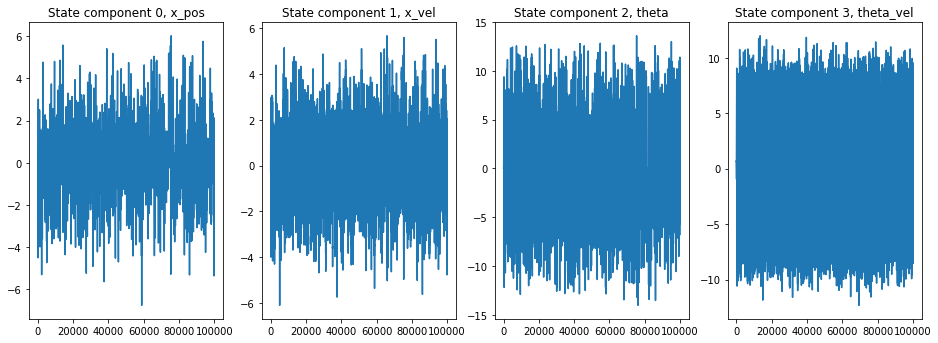

In [5]:
# To understand every components lets run some random experiments and visualize the states.

env = gym.make('CartPole-v0')
states = []
actions = []
for n_samples in range(1000):
    env.reset()
    for _ in range(100):
        action = env.action_space.sample()
        state, reward, done, info = env.step(action)
        actions.append(action)
        states.append(state)
        if done:
            break
            
env.close()

component_names = ["x_pos", "x_vel", "theta", "theta_vel"]
fig = plt.figure(figsize=(16,12))
for _ in range(4):
    plt.subplot(2,4,_+1)
    plt.plot([state[_] for state in states]) 
    plt.title("State component %i, %s" % (_, component_names[_]))
plt.show()

In [36]:
# Initializing the environement
env = gym.make('CartPole-v0')
action_space = [0,1]

segmentation = [[],
                [],
                [-radians(6), -radians(3), 0, radians(3), radians(6)],
                [-radians(50) + _ * radians(100)/10 for _ in range(11)]]

Q_ = Q(init_range=[0,0],
       discrete=False, segmentation=segmentation, actions_size=len(action_space)) 

ql = QLearner(Q_=Q_, env=env, gamma=1, max_steps=200,
               epsilon=0.5, epsilon_decay=0.9, epsilon_min=0.1, epsilon_decay_every=50, 
               lr0=1, lr_decay=0.01, min_lr=0.01, verbose=1)
policy, rewards, _ = ql.fit(1000)

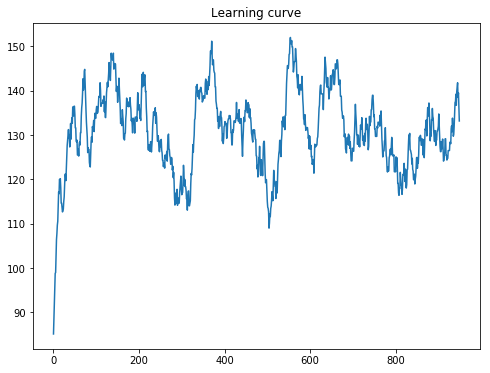

In [37]:
plt.figure(figsize=(8,6))
plt.plot(utils.rolling_average(rewards, 50))
plt.title("Learning curve")
plt.show()

In [38]:
env = Env('CartPole-v0', "./gym-results/CartPole/RL")
_ = env.run(steps=200, policy=policy, **{"be_greedy":True})
env.display_run()

In [40]:
# Initializing the environement
def scoring_function(init_range, epsilon, epsilon_decay, epsilon_min, epsilon_decay_every,
                         lr0, lr_decay, min_lr, n_runs=4):
    segmentation = [[],
                    [],
                    [-radians(6), -radians(3), 0, radians(3), radians(6)],
                    [-radians(50) + _ * radians(100)/10 for _ in range(11)]]
    env = gym.make('CartPole-v0')
    action_space = [0,1]
    Q_ = Q(init_range=[0,init_range], 
           discrete=False, segmentation=segmentation, actions_size=len(action_space)) 

    ql = QLearner(Q_=Q_, env=env, gamma=1, max_steps=200,
                  epsilon=epsilon, epsilon_decay=epsilon_decay, 
                  epsilon_min=epsilon_min, epsilon_decay_every=epsilon_decay_every, 
                  lr0=lr0, lr_decay=lr_decay, min_lr=min_lr, verbose=0)
    _, _, best_reward = ql.fit(100)

    return best_reward

params_values = {
    "init_range" : [0, 1],
    "epsilon": [1, 0.1],
    "epsilon_decay": [0.9, 0.1],
    "epsilon_min": [0.1, 0.01],
    "epsilon_decay_every": [5, 20],
    "lr0": [1, 0.1],
    "lr_decay": [0.01, 0.1],
    "min_lr": [0.1, 0.01]
}

gs = GridSearch(scoring_function, 8, 4)
gs(params_values)

({'init_range': 1,
  'epsilon': 1,
  'epsilon_decay': 0.9,
  'epsilon_min': 0.1,
  'epsilon_decay_every': 20,
  'lr0': 1,
  'lr_decay': 0.01,
  'min_lr': 0.1},
 194.5)

In [45]:
# Initializing the environement
env = gym.make('CartPole-v0')
Q_ = Q(init_range=[0,1],
       discrete=False, segmentation=segmentation, actions_size=len(action_space)) 
ql = QLearner(Q_=Q_, env=env, gamma=1, max_steps=200,
               epsilon=1, epsilon_decay=0.9, epsilon_min=0.1, epsilon_decay_every=20, 
               lr0=1, lr_decay=0.01, min_lr=0.1)
policy, rewards, best_reward = ql.fit(100)
best_reward

200.0

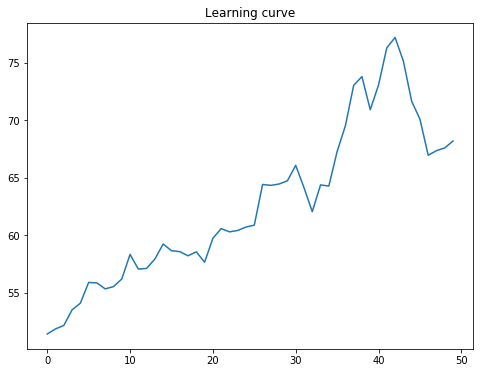

In [46]:
plt.figure(figsize=(8,6))
plt.plot(utils.rolling_average(rewards, 50))
plt.title("Learning curve")
plt.show()

In [47]:
env = Env('CartPole-v0', "./gym-results/CartPole/RL")
_ = env.run(steps=200, policy=policy, **{"be_greedy":True})
env.display_run()